## Chapter 2-4, 2강 Computer Vision 전이학습(MobileNet/EfficientNet)으로 CIFAR-10 분류
- 데이터 다운로드 → 데이터 탐색 → 사전학습 백본 선택 → 학습/검증 → 시각화(정확도/손실) → 혼동행렬 → 오류 사례 분석


### 0. 환경 설정 및 라이브러리


In [6]:
# 필요한 라이브러리 임포트 (첫 강의 스타일 유지)
import os, time, random, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

from sklearn.metrics import confusion_matrix, classification_report
import itertools

# 디바이스 설정 및 시드 고정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# 한글 폰트 설정 (첫 강의와 동일)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False


Device: cpu


### 1. 데이터 다운로드 및 DataLoader 설정


In [7]:
# 전처리: 전이학습 입력 규격(224) + ImageNet 통계로 정규화
# 첫 강의의 Normalize 흐름을 유지하되, 해상도만 224로 증가
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std  = (0.229, 0.224, 0.225)

train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# 데이터셋 다운로드/로딩 (CIFAR-10)
root = './data'
train_full = datasets.CIFAR10(root=root, train=True, download=True, transform=train_tf)
test_full  = datasets.CIFAR10(root=root, train=False, download=True, transform=test_tf)
class_names = train_full.classes

# 학습/테스트 SUBSET 적용 (예: 10%만 사용)
SUBSET = 0.1  # 10% 사용
val_ratio = 0.2

# Train subset
full_len = len(train_full)
subset_len = int(full_len * SUBSET)
train_subset, _ = random_split(train_full, [subset_len, full_len - subset_len])

# subset에서 train/val 분할 (비율 유지)
val_len   = int(subset_len * val_ratio)
train_len = subset_len - val_len
train_set, val_set = random_split(train_subset, [train_len, val_len])

# Test subset
test_full_len = len(test_full)
test_subset_len = int(test_full_len * SUBSET)
test_set, _ = random_split(test_full, [test_subset_len, test_full_len - test_subset_len])

# DataLoader 구성 (배치/섞기/num_workers 동일 스타일)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_set,   batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_set,  batch_size=32, shuffle=False, num_workers=2)

print('Train/Val/Test sizes:', len(train_set), len(val_set), len(test_set))
print('Sample image shape (C,H,W):', next(iter(train_loader))[0][0].shape)


Files already downloaded and verified
Files already downloaded and verified
Train/Val/Test sizes: 4000 1000 1000
Sample image shape (C,H,W): torch.Size([3, 224, 224])


### 2. 사전학습 백본 선택 (MobileNetV3 Small / EfficientNet-B0)


In [8]:
# torchvision 사전학습 모델 로드 + 분류기 헤드 교체(10 클래스)
# 첫 강의와 동일한 인터페이스(모델 → train_model → plot_hist 등)를 그대로 사용합니다.

NUM_CLASSES = 10
BACKBONE = 'mobilenet'  # 'mobilenet' | 'efficientnet'

if BACKBONE == 'mobilenet':
    # MobileNetV3 Small
    weights = models.MobileNet_V3_Small_Weights.DEFAULT
    base = models.mobilenet_v3_small(weights=weights)
    in_features = base.classifier[-1].in_features
    base.classifier[-1] = nn.Linear(in_features, NUM_CLASSES)
elif BACKBONE == 'efficientnet':
    # EfficientNet-B0
    weights = models.EfficientNet_B0_Weights.DEFAULT
    base = models.efficientnet_b0(weights=weights)
    in_features = base.classifier[-1].in_features
    base.classifier[-1] = nn.Linear(in_features, NUM_CLASSES)
else:
    raise ValueError('BACKBONE must be "mobilenet" or "efficientnet"')

model = base.to(device)

# feature extractor로 쓸 경우, 백본 동결 옵션(필요 시)
FREEZE_BACKBONE = False
if FREEZE_BACKBONE:
    for name, p in model.named_parameters():
        # 분류기 헤드만 학습되도록
        if 'classifier' not in name:
            p.requires_grad = False

# 입력 전처리 안내 (weights.transforms() 참고)
print('Selected backbone:', BACKBONE)
print('Trainable params:', sum(p.numel() for p in model.parameters() if p.requires_grad))


Selected backbone: mobilenet
Trainable params: 1528106


### 3. 학습/검증 루프 (첫 강의와 동일 인터페이스)


In [9]:
# train_epoch / eval_epoch / train_model / plot_hist: 첫 강의와 동일한 형태

def train_epoch(model, loader, loss_fn, optim_):
    model.train()
    tl = 0; tc = 0; n = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optim_.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optim_.step()
        tl += loss.item() * x.size(0)
        tc += (out.argmax(1) == y).sum().item()
        n  += x.size(0)
    return tl/n, tc/n

@torch.no_grad()
def eval_epoch(model, loader, loss_fn):
    model.eval()
    tl = 0; tc = 0; n = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = loss_fn(out, y)
        tl += loss.item() * x.size(0)
        tc += (out.argmax(1) == y).sum().item()
        n  += x.size(0)
    return tl/n, tc/n

criterion = nn.CrossEntropyLoss()

def train_model(model, epochs=8, lr=1e-3):
    optim_ = optim.Adam(model.parameters(), lr=lr)
    hist = {'train_acc':[], 'val_acc':[], 'train_loss':[], 'val_loss':[]}
    for ep in range(1, epochs+1):
        tr_l, tr_a = train_epoch(model, train_loader, criterion, optim_)
        va_l, va_a = eval_epoch(model, val_loader, criterion)
        hist['train_loss'].append(tr_l); hist['val_loss'].append(va_l)
        hist['train_acc'].append(tr_a);  hist['val_acc'].append(va_a)
        print(f'[Ep {ep}/{epochs}] train={tr_a:.3f}/{tr_l:.3f}  val={va_a:.3f}/{va_l:.3f}')
    return hist

# 학습곡선 플로팅 함수 (첫 강의 동일)
def plot_hist(h, title):
    plt.figure(figsize=(6,4))
    plt.plot(h['train_acc'], label='train_acc')
    plt.plot(h['val_acc'], label='val_acc')
    plt.title(title+'(Accuracy)'); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(h['train_loss'], label='train_loss')
    plt.plot(h['val_loss'], label='val_loss')
    plt.title(title+'(Loss)'); plt.legend(); plt.tight_layout(); plt.show()


### 4. 학습 실행


In [10]:
print('TRAIN_start')
hist = train_model(model, epochs=2, lr=1e-3)
print('TRAIN_end')


TRAIN_start
[Ep 1/2] train=0.720/0.820  val=0.754/0.776
[Ep 2/2] train=0.868/0.372  val=0.794/0.690
TRAIN_end


### 5. 학습 곡선(정확도/손실) 시각화


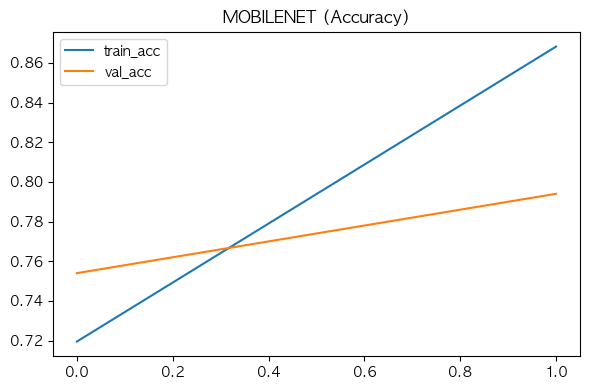

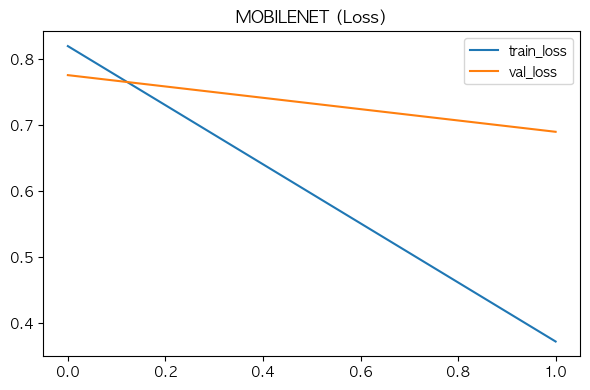

In [11]:
plot_hist(hist, f'{BACKBONE.upper()} ' )


### 6. 오분류 분석 (혼동행렬, Top-3 혼동 쌍, 사례 시각화)


In [ ]:
# # 전체 테스트셋 예측값 얻기 (첫 강의와 동일한 패턴)
# @torch.no_grad()
# def get_all_preds(model, loader):
#     model.eval()
#     ys=[]; ps=[]
#     for x, y in loader:
#         x = x.to(device)
#         out = model(x)
#         ps.append(out.argmax(1).cpu().numpy())
#         ys.append(y.numpy())
#     return np.concatenate(ys), np.concatenate(ps)

# # 예측 수행 및 혼동행렬 시각화
# y_true, y_pred = get_all_preds(model, test_loader)
# cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))

# plt.figure(figsize=(6,5))
# plt.imshow(cm, interpolation='nearest')
# plt.title('Confusion Matrix')
# plt.colorbar()
# plt.xticks(range(NUM_CLASSES), class_names, rotation=45)
# plt.yticks(range(NUM_CLASSES), class_names)
# plt.tight_layout(); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

# # Top-3 혼동 클래스 쌍 추출
# pairs = []
# for i in range(NUM_CLASSES):
#     for j in range(NUM_CLASSES):
#         if i!=j and cm[i,j] > 0:
#             pairs.append(((i,j), cm[i,j]))

# pairs = sorted(pairs, key=lambda x: x[1], reverse=True)[:3]
# print('Top-3 혼동 클래스 쌍:', [(class_names[i], class_names[j], n) for (i,j), n in pairs])

# # 혼동 사례 이미지 표시: 원본 CIFAR-10 테스트셋 로드(ToTensor만)
# from torchvision import datasets as tvdatasets
# raw_test = tvdatasets.CIFAR10(root='./data', train=False, download=False, transform=transforms.ToTensor())

# from torch.utils.data import DataLoader as DL

# def find_mismatch_indices(true_label, pred_label, max_show=6):
#     out_idx = []
#     count = 0
#     ptr = 0
#     for batch_x, batch_y in DL(test_set, batch_size=32, shuffle=False):
#         with torch.no_grad():
#             logits = model(batch_x.to(device))
#             preds = logits.argmax(1).cpu().numpy()
#         for k in range(len(batch_y)):
#             if batch_y[k].item()==true_label and preds[k]==pred_label:
#                 out_idx.append(ptr+k)
#                 count += 1
#                 if count >= max_show:
#                     return out_idx
#         ptr += len(batch_y)
#     return out_idx

# # Top-3 쌍별 사례 6장씩 시각화
# for (i,j), _ in pairs:
#     ids = find_mismatch_indices(i,j, max_show=6)
#     if not ids: continue
#     plt.figure(figsize=(6,3))
#     for k, idx in enumerate(ids):
#         img, _ = raw_test[idx]
#         plt.subplot(2,3,k+1)
#         plt.imshow(img.permute(1,2,0))
#         plt.axis('off')
#         plt.title(f'T:{class_names[i]} → P:{class_names[j]}')
#     plt.suptitle(f'혼동 사례: {class_names[i]} vs {class_names[j]}')
#     plt.tight_layout(); plt.show()


In [14]:
pairs = []
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        if i != j and cm[i, j] > 0:
            pairs.append(((i, j), cm[i, j]))
pairs = sorted(pairs, key=lambda x: x[1], reverse=True)[:3]
print('Top-3 혼동 클래스 쌍:', [(class_names[i], class_names[j], n) for (i,j), n in pairs])

Top-3 혼동 클래스 쌍: [('dog', 'cat', 28), ('deer', 'horse', 16), ('ship', 'airplane', 15)]


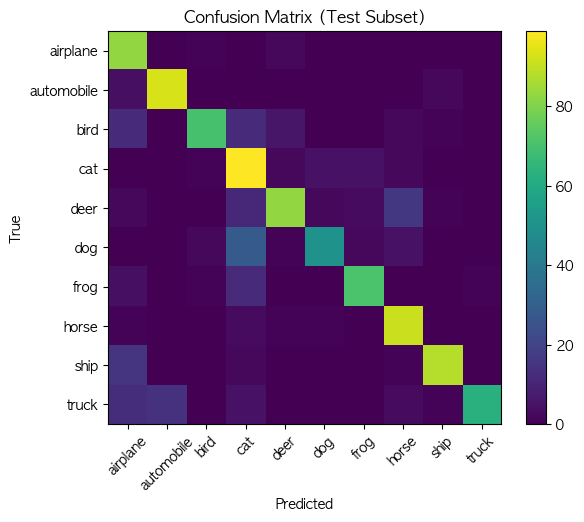

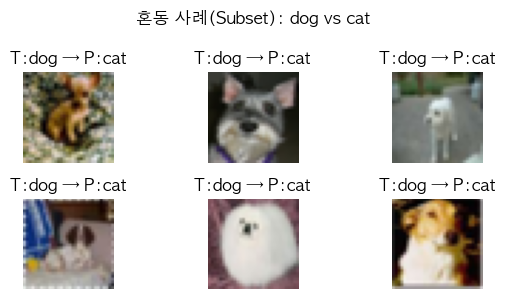

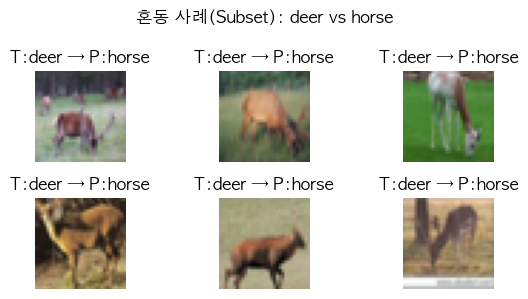

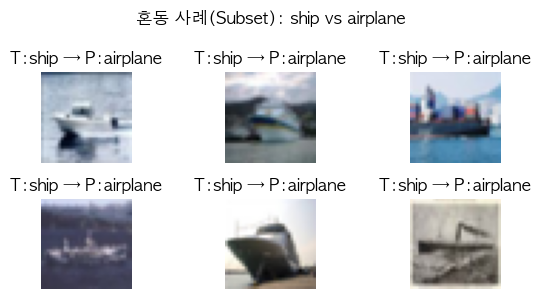

In [15]:
# SUBSET 적용 시 혼동 사례 인덱스 매핑 보정
# random_split이 Subset 객체를 생성하므로, Subset.indices를 사용해 원본 인덱스로 역매핑합니다.

# raw_test: 원본 이미지를 보기 위한 ToTensor만 적용한 전체 테스트셋 (subset 아님)
raw_test = datasets.CIFAR10(root='./data', train=False, download=False, transform=transforms.ToTensor())

# test_set은 random_split으로 만들어진 Subset
subset_to_full_idx = np.array(test_set.indices) if hasattr(test_set, 'indices') else np.arange(len(raw_test))

from torch.utils.data import DataLoader as DL

@torch.no_grad()
def get_all_preds_with_subset(model, subset_loader):
    model.eval()
    ys=[]; ps=[]
    for x, y in subset_loader:
        x = x.to(device)
        out = model(x)
        ps.append(out.argmax(1).cpu().numpy())
        ys.append(y.numpy())
    return np.concatenate(ys), np.concatenate(ps)

# 혼동행렬은 subset 기준으로 다시 계산
y_true, y_pred = get_all_preds_with_subset(model, test_loader)
cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (Test Subset)')
plt.colorbar()
plt.xticks(range(NUM_CLASSES), class_names, rotation=45)
plt.yticks(range(NUM_CLASSES), class_names)
plt.tight_layout(); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

# subset 내의 혼동 사례 인덱스를 원본 인덱스로 변환하여 시각화
def find_mismatch_indices_subset(true_label, pred_label, max_show=6):
    out_idx = []
    count = 0
    ptr = 0
    for batch_x, batch_y in DL(test_set, batch_size=128, shuffle=False):
        logits = model(batch_x.to(device))
        preds = logits.argmax(1).cpu().numpy()
        for k in range(len(batch_y)):
            if batch_y[k].item()==true_label and preds[k]==pred_label:
                # subset 인덱스(ptr+k) → full 인덱스
                full_idx = subset_to_full_idx[ptr+k]
                out_idx.append(full_idx)
                count += 1
                if count >= max_show:
                    return out_idx
        ptr += len(batch_y)
    return out_idx

for (i,j), _ in pairs:
    ids_full = find_mismatch_indices_subset(i,j, max_show=6)
    if not ids_full: continue
    plt.figure(figsize=(6,3))
    for k, idx in enumerate(ids_full):
        img, _ = raw_test[idx]
        plt.subplot(2,3,k+1)
        plt.imshow(img.permute(1,2,0))
        plt.axis('off')
        plt.title(f'T:{class_names[i]} → P:{class_names[j]}')
    plt.suptitle(f'혼동 사례(Subset): {class_names[i]} vs {class_names[j]}')
    plt.tight_layout(); plt.show()
